In [212]:
# IMPORT LIBRARIES #
import numpy as np
import os
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


#Twitter credentials for the app
consumer_key = 'cFGNMBqCp8qERyYyer5SHzoyK'
consumer_secret = '27rIysNwcEIMu84fiXicbKIRrQivMddOOExJqEIDlMu0TpdOGr'
access_key= '1252924412988469249-227b34yh3EDm68RAHRTWe3hnq7WJdN'
access_secret = '6MbHwQPgjQNVZYGsobdDuI0R2vD637PNN3VTmzZePJAqx'


#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

#file path for listenend tweets "/home/up939271/boris_johnson_data_extraction/boris_johnson_data.csv" for clearer path
boris_johnson_tweets = "/home/up939271/boris_johnson_data_extraction/boris_johnson_data.csv"


#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
        'favorite_count', 'retweet_count', 'original_author', 'possibly_sensitive', 'hashtags',
        'user_mentions', 'place', 'place_coord_boundaries']

#set two date variables for date range
start_date = '2018-01-01'
end_date = '2020-05-20'

# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)


#mrhod clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)

    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)


    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []

    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)

#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json

            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue

            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue


           #tweepy preprocessing called for basic preprocessing
        
        
            clean_text = p.clean(status['text'])
            

            #call clean_tweet method for extra preprocessing
            
            
            filtered_tweet=clean_tweets(clean_text)
            
            

            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
            

            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity

            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]

            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])

            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)

            # hashtagas and mentiones are saved using comma separted
            
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)

            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)

            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)

            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

#declare keywords as a query for 'boris johnson'
boris_johnson_keywords = '#boris OR #PM OR primeminister'


#call main method passing keywords and file path
write_tweets(boris_johnson_keywords,  boris_johnson_tweets)


In [5]:
import numpy as np
import os
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [6]:
df = pd.read_csv('boris_johnson_dat.csv', delimiter =',', skiprows = [1])

In [7]:
df.head(5)

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,remarks,lang,...,place_coord_boundaries,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,score,mark
0,1.26E+18,Sat May 23 12:28:53 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",Who is actually running this country? Answers ...,Who actually running country Answers postcard ...,"Sentiment(polarity=0.0, subjectivity=0.1)",0,0.1,neutral,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,weak_positive
1,1.26E+18,Sat May 23 12:28:19 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",@Number10cat with more sense than any of the g...,sense government ministers far,"Sentiment(polarity=0.1, subjectivity=1.0)",0.1,1,weak_positive,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,weak_positive
2,1.26E+18,Sat May 23 12:27:43 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @HHepplewhite: We’ve had enough hatred #MS...,We ’ enough hatred The public enough division ...,"Sentiment(polarity=0.0, subjectivity=0.3555555...",0,0.4,neutral,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,weak_positive
3,1.26E+18,Sat May 23 12:27:26 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",@tesssummers98 That's why the media hates #Cum...,That 's media hates He got Brexit done never f...,"Sentiment(polarity=0.0, subjectivity=0.0)",0,0,neutral,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,weak_positive
4,1.26E+18,Sat May 23 12:27:02 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",#Cummings this man could go down in modern UK ...,man could go modern UK history disastrously su...,"Sentiment(polarity=0.475, subjectivity=0.625)",0.5,0.6,strong_positive,en,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,strong_positive


In [8]:
print(len(df))

21603


In [9]:
import matplotlib.pyplot as plt

In [10]:
y = df['subjectivity'];
x = df['polarity']

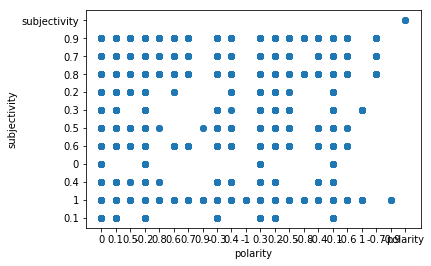

In [11]:
plt.xlabel('polarity')
plt.ylabel('subjectivity')

plt.scatter(x,y)


In [12]:
ph = df['remarks']


In [14]:
ph

0                neutral
1          weak_positive
2                neutral
3                neutral
4        strong_positive
5                neutral
6                neutral
7        strong_positive
8                neutral
9                neutral
10               neutral
11         weak_positive
12         weak_positive
13               neutral
14               neutral
15         weak_negative
16               neutral
17       strong_positive
18         weak_positive
19               neutral
20               neutral
21               neutral
22       strong_positive
23       strong_positive
24               neutral
25               neutral
26               neutral
27               neutral
28       strong_positive
29               neutral
              ...       
21573            neutral
21574            neutral
21575            neutral
21576            neutral
21577            neutral
21578      weak_positive
21579    strong_positive
21580            neutral
21581            neutral


In [15]:
location= df['place'].value_counts()
location[location>=100]

London, England            502
United Kingdom             502
England, United Kingdom    416
London                     398
North London               378
UK                         292
India                      160
World                      134
Scotland                   128
England                    126
New Delhi, India           120
South East, England        110
Name: place, dtype: int64

In [142]:
from collections import Counter

In [30]:
Counter(ph)

Counter({'neutral': 10999,
         'weak_positive': 5257,
         'strong_positive': 1311,
         'weak_negative': 2555,
         nan: 174,
         'strong_negative': 1307})

In [37]:
rf = ph.unique()
rf

array(['neutral', 'weak_positive', 'strong_positive', 'weak_negative',
       nan, 'strong_negative'], dtype=object)

In [48]:
i = neutral = 10999/21603 *100
j = weak_positive= 5257/21603 *100
k = weak_negative= 2555/21603 *100
l = strong_positive= 1311/21603 *100
m = strong_negative= 1307/21603 *100
n = nan = 174/21603 *100

o = (i,j,k,l,m,n)

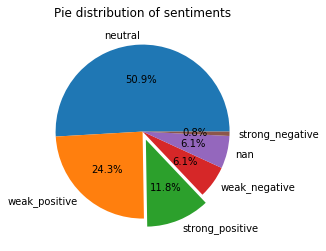

In [49]:
plt.pie(o,labels = rf, explode = (0,0,0.1,0,0,0), autopct = '%1.1f%%')

plt.title('Pie distribution of sentiments')
plt.show()

In [50]:
bjd = pd.read_csv('boris_johnson_dat.csv')

In [51]:
bjd['clean_text']

0                  directed inquiry committee formed star…
1        Who actually running country Answers postcard ...
2                           sense government ministers far
3        We ’ enough hatred The public enough division ...
4        That 's media hates He got Brexit done never f...
5        man could go modern UK history disastrously su...
6        We ’ enough hatred The public enough division ...
7        Here ’ report ,000 fines handed breaking lockd...
8        Share stories vs rule breaking Even many suppo...
9                                         wishes country …
10       Here ’ report ,000 fines handed breaking lockd...
11       We ’ enough hatred The public enough division ...
12       right one Rishi You ’ look back wish ’ sat one...
13       This n't first time happened remember Robert h...
14       rd May historic day ji defeated Gandhi Dynasty...
15        You ’ defend anyone minority types agenda alrea…
16       Is current UK Government nothing corrupt bunch.

In [52]:
bjd.to_csv('/home/up939271/wordcloud.txt')

In [53]:
text = open('wordcloud.csv').read()



In [54]:
textt = str(bjd['clean_text'])



In [56]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

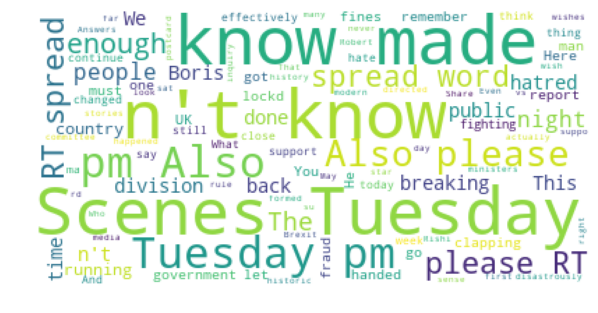

In [61]:
text = open('wordcloud.txt').read()

#wordcloud = WordCloud(width=500, height=500, random_state=21, max_font_size=200, background_color="black").generate(textt)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(textt)
# Generate plot

plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation="hamming")

#plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Generate plot







In [94]:
bjd = pd.read_csv('boris_johnson_dat.csv')